# What is Stable Diffusion?
with 🤗 Diffusers

**Pedro Cuenca, Patrick von Platen, Suraj Patil, Jeremy Howard**

This notebook introduces Stable Diffusion, the highest-quality open source text to image model as of now, small enough to run in consumer GPUs,
using the 🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers).<br>
Understanding state-of-the-art (SOTA) generative models requires a deep understanding of many of the fundamental blocks in modern machine learning models. 
This notebook shows a glimpse of its main components.

_If you open this notebook in Colab, please uncomment and run the following cell. If you get type errors when generating your first image, please try to upgrade your transformers installation using `pip install --upgrade transformers`_

To run Stable Diffusion on your computer you have to accept the model license. It's an open CreativeML OpenRail-M license that claims no rights on the outputs you generate and prohibits you from deliberately producing illegal or harmful content. The [model card](https://huggingface.co/CompVis/stable-diffusion-v1-4) provides more details. If you do accept the license, you need to be a registered user in 🤗 Hugging Face Hub and use an access token for the code to work. You have two options to provide your access token:

* Use the `huggingface-cli login` command-line tool in your terminal and paste your token when prompted. It will be saved in a file in your computer.
* Or use `notebook_login()` in a notebook, which does the same thing.

In [1]:
!pip list | grep -e diffusers -e fastcore -e transformers -e huggingface-hub -e fastai -e fastdownload #-e torch 

diffusers                         0.11.1
fastai                            2.7.9
fastcore                          1.5.27
fastdownload                      0.0.7
huggingface-hub                   0.10.1
transformers                      4.23.1


In [2]:
from pathlib import Path
from huggingface_hub import notebook_login
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

In [3]:
import logging
logging.disable(logging.WARNING)

[`StableDiffusionPipeline`](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion#diffusers.StableDiffusionPipeline) is an end-to-end [diffusion inference pipeline](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion) that allows you to start generating images with just a few lines of code. <br>

A **"pipeline"** indicates a sequence of steps that when combined complete some task. <br>
By "inference" we refer to using an existing model to generate samples (in this case, images), as opposed to "training" (or fine-tuning) models using new data.

We use [`from_pretrained`](https://huggingface.co/docs/diffusers/main/en/api/diffusion_pipeline#diffusers.DiffusionPipeline.from_pretrained) to create the pipeline 
and download the pretrained weights. 
We indicate that we want to use the `fp16` (half-precision) version of the weights, and we tell `diffusers` to expect the weights in that format. 
Half precision performs faster inference with almost no discernible difference in quality. <br>
The string passed to `from_pretrained` in this case (`CompVis/stable-diffusion-v1-4`) is the repo id of a pretrained pipeline hosted on [Hugging Face Hub](https://huggingface.co/models); <br>
it can also be a path to a directory containing pipeline weights. 
The weights for all the models in the pipeline will be downloaded and cached the first time you run this cell.

---

### What are the components of Stable Diffusion

There are three main components in latent diffusion.

1. An autoencoder (VAE).
2. A [U-Net](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb#scrollTo=wW8o1Wp0zRkq).
3. A text-encoder, *e.g.* [CLIP's Text Encoder](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel).

The output of the U-Net, being the noise residual, is used to compute a denoised latent image representation via a scheduler algorithm. <br> 
Many different scheduler algorithms can be used for this computation, each having its pros and cons. <br> 
For Stable Diffusion, we recommend using one of:

- [PNDM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_pndm.py) (used by default)
- [DDIM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_ddim.py)
- [K-LMS scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_lms_discrete.py)

### Latents and callbacks

**Stable** Diffusion is based on a particular type of diffusion model called **Latent Diffusion**, proposed in [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752).<br>
General diffusion models are MLs trained to *denoise* random Gaussian noise step by step, to get to a sample of interest, such as an *image*.
For a more detailed overview of how they work, check [this colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb).
Diffusion models have shown to achieve state-of-the-art results for generating image data. 
But they have downsides: 
- the reverse denoising process is slow. 
- consume a lot of memory because they operate in pixel space, (expensive for high-resolution images). 

Therefore, it is challenging to train these models and also use them for inference.
<br>
Latent diffusion can reduce the memory and compute complexity by applying the diffusion process over a lower dimensional _latent_ space, 
instead of using the actual pixel space. 
<mark> In latent diffusion the model is trained to generate latent (compressed) representations of the images.</mark>

In [4]:
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline
import torch
torch.manual_seed(1)

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16).to("cuda")

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

In [5]:
from PIL import Image

def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

The Stable Diffusion pipeline can send intermediate latents to a callback function we provide. 
By running these latents through the image decoder (the `vae` component of the pipeline), 
we can see how the denoising process progresses and the image unfolds.

We haven't been doing any of that training ourselves except for fine tuning, because it takes a very long time and compute resources. 
Instead we take pre-trained models and do inference, put an example of what we have an embedding for, e.g., a handwritten digit 3.
We put in some random noise into the U-Net and then it outputs a prediction of which  bits of noise you could remove to leave behind an image of "3". 
Initially it's going to do a bad job, so we subtract just a little bit of that noise from the image to make it a little bit less noisy, and we do it again a few times.  

Inside the pipeline what is going on is all of the steps that we saw in Lesson 9. <br>
The `callback_steps=12` indicates that every 12 steps it calls the `latents_callback(i, t, latents)`.
We just make an image and stick it on the edge end of an `images` array.
With it we can interact with the pipeline (without needing to rewrite it).
This is how to interact with a pipeline without rewriting it from scratch. 

  0%|          | 0/50 [00:00<?, ?it/s]

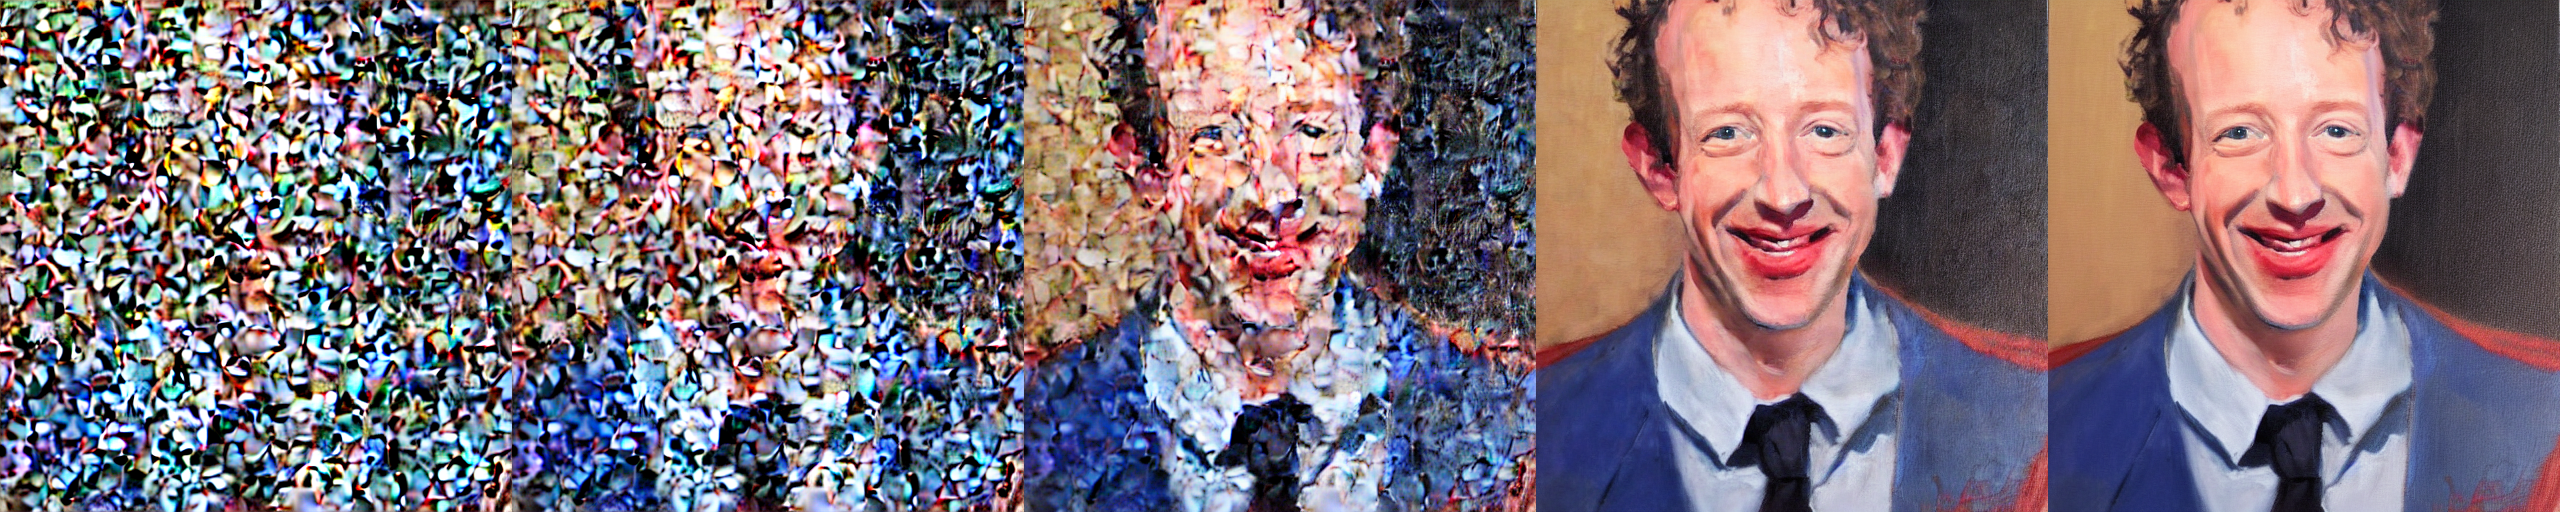

In [6]:
vae = pipe.vae
images = []

def latents_callback(i, t, latents):
    latents = 1 / 0.18215 * latents     # scaling constant given by paper
    image = vae.decode(latents).sample[0]
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(1, 2, 0).numpy()
    images.extend(pipe.numpy_to_pil(image))

prompt = "Portrait painting of Jeremy Howard looking happy."
torch.manual_seed(9000)
final_image = pipe(prompt, callback=latents_callback, callback_steps=12).images[0]
images.append(final_image)

image_grid(images, rows=1, cols=len(images))

So here's what that looks like for creating “a smiling picture of Jeremy Howard”. 
We print out the noise at steps 0, every 12 steps, and we see the first signs of a face starting to appear.  
In the early days this took a thousand steps and now shortcuts make it take 60 steps. 
This doesn't look like normal noise  because we are using VAE latents, which look like this.

**Why is latent diffusion fast and efficient?**

Since the U-Net of latent diffusion models operates on a lower dimensional space, it reduces the memory and compute requirements compared to pixel-space diffusion models. For example, the autoencoder used in Stable Diffusion has a reduction factor of 8 but uses 4 channels instead of 3. Hence an image of shape `(3, 512, 512)` becomes `(4, 64, 64)` in latent space, which requires `8 × 8 × 3/4 = 48` times less memory. <br>
This is why it's possible to generate `512 × 512` images so quickly, even on 16GB GPUs.

In [7]:
del pipe
torch.cuda.empty_cache()

## Looking inside the pipeline

The inference pipeline is just a small piece of code that plugs the components together and performs the inference loop. [This is all there it to is](https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py#L204).
<br>
We'll go through the process of loading and plugging the pieces to see how we could have written it ourselves. We'll start by loading all the modules that we need from their pretrained weights.
<br>
Recall that the 3 main components in latent diffusion are: (1) An autoencoder (VAE), 
(2) a U-Net, and (3) a text-encoder, e.g. CLIP's Text Encoder.
<br>
First, we need the text encoder and the tokenizer. 
These come from the text portion of a standard CLIP model, so we'll use the weights released by Open AI.

In [8]:
from transformers import CLIPTextModel, CLIPTokenizer

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

Next we'll load the `vae` and the `unet`. These are distinct models whose weights are stored inside folders of the Stable Diffusion repository. <br>
We can use the `subfolder` argument to refer to [these locations](https://huggingface.co/CompVis/stable-diffusion-v1-4/tree/main).

In [9]:
from diffusers import AutoencoderKL, UNet2DConditionModel

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae",torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet",torch_dtype=torch.float16).to("cuda")

### Scheduler
Next, we need a scheduler to converts "time steps" into the amount of noise.
To make things a bit different, we'll use another scheduler. 
The standard pipeline uses the [PNDM Scheduler](https://arxiv.org/abs/2202.09778), but we'll use [Katherine Crowson's](https://github.com/crowsonkb) excellent K-LMS scheduler.

We need to be careful to use the same noising schedule that was used during training. 
The schedule is defined by the number of noising steps and the amount of noise added at each step, which is derived from the _beta_ parameters.
We have to make sure that matches, so we use these numbers that we're given. 

In the case of the k-LMS scheduler, this is how the betas evolve during the 1000 steps of the noising process used during training:

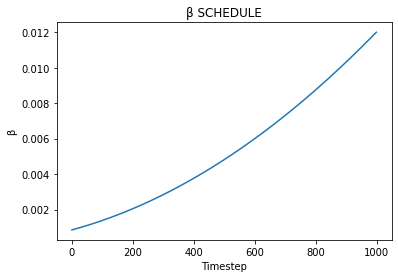

In [10]:
import matplotlib.pyplot as plt

beta_start, beta_end = 0.00085, 0.012   # these numbers are given
betas = torch.linspace(beta_start**0.5, beta_end**0.5, 1000) ** 2

plt.plot(betas)
plt.title('β SCHEDULE')
plt.xlabel('Timestep')
plt.ylabel('β')
plt.show()

In [11]:
from diffusers import LMSDiscreteScheduler

LSconf = LMSDiscreteScheduler().config
LSconf

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.0001),
            ('beta_end', 0.02),
            ('beta_schedule', 'linear'),
            ('trained_betas', None),
            ('prediction_type', 'epsilon')])

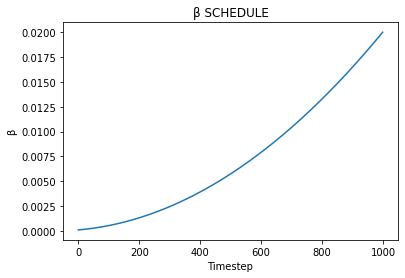

In [12]:
#import matplotlib.pyplot as plt

beta_start, beta_end = LSconf["beta_start"], LSconf["beta_end"] # 0.00085, 0.012   # these numbers are given
betas = torch.linspace(beta_start**0.5, beta_end**0.5, 1000) ** 2

plt.plot(betas)
plt.title('β SCHEDULE')
plt.xlabel('Timestep')
plt.ylabel('β')
plt.show()

In [13]:
scheduler = LMSDiscreteScheduler(beta_start=beta_start, beta_end=beta_end, beta_schedule="scaled_linear", num_train_timesteps=1000)

scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.0001),
            ('beta_end', 0.02),
            ('beta_schedule', 'scaled_linear'),
            ('trained_betas', None),
            ('prediction_type', 'epsilon')])

We now define the parameters we'll use for generation.

In contrast with the previous examples, we set `num_inference_steps` to 70 to get an even more defined image.

In [14]:
#prompt = ["a photograph of an astronaut riding a horse"]
prompt = ["an astronaut riding a black horse photorealistic 4K"]
height = 512
width = 512
num_inference_steps = 70
guidance_scale = 7.5
batch_size = 1

### Step 1. Tokenize the prompt. 

The model requires the same number of tokens for every prompt, so padding (here 49407) is used to ensure we meet the required length.

In [15]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_input['input_ids']

tensor([[49406,   550, 18376,  6765,   320,  1449,  4558,  1153, 16157,   275,
           330, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]])

The tokenizer returns a tuple of `inputs_ids`  (lookups into a vocabulary),
and `attention_mask` which tells it which ones are actual  words as opposed to padding.

In [16]:
text_input.keys()

dict_keys(['input_ids', 'attention_mask'])

In [17]:
len(text_input), text_input['input_ids'].shape, text_input['attention_mask'].shape

(2, torch.Size([1, 77]), torch.Size([1, 77]))

In [18]:
tokenizer.decode(49407) # padding

'<|endoftext|>'

In [19]:
type(text_input)

transformers.tokenization_utils_base.BatchEncoding

In [20]:
text_input['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])

We can now take those input IDs, put them on the GPU, and run them through the CLIP encoder. 
The text encoder gives us (inference) the embeddings for the text prompt we used.

In [21]:
text_embeddings = text_encoder(text_input.input_ids.to("cuda"))[0]   # One image run thru the clip encoder
text_embeddings.shape   

torch.Size([1, 77, 768])

And we got `text_embeddings` batch size of one (one image) gives us a 77x768 embeddings, 
because we've got 77 tokens and each one is a 768 long vector. 
These are the CLIP embeddings for the prompt ("a photograph of an astronaut riding a horse").

For the classifier-free guidance we also need to get the embeddings required to perform **unconditional** generation, which is achieved with an **empty string** "". <br>
The model is free to go in whichever direction it wants as long as it results in a reasonably-looking image. <br>

In [22]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
uncond_embeddings = text_encoder(uncond_input.input_ids.to("cuda"))[0]
uncond_embeddings.shape

torch.Size([1, 77, 768])

For **classifier-free guidance**, we need to do two forward passes.<br> 
One with the conditioned input (`text_embeddings`), and another with the unconditional embeddings (`uncond_embeddings`).<br>

In practice (to improve GPU performance), we can concatenate both into a single batch to avoid doing two forward passes.

In [23]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

To start the denoising process, we start from pure Gaussian (normal) noise. 
So that's just random numbers, normally generated, normally distributed random numbers of size one  (our batch size).
These are our initial "latents".... but they are just noise.
We divide height and weight by 8 because that is what the VAE does.
It allows us to create things that are eight times smaller by height and width,  
and then it's going to expand it up again for us later, that's why this is so much faster.  <br>
After we put it on the GPU, `.half()` is converting into half precision (fp_16), making it half as big in memory. 
Modern GPUs are faster if we do that.

In [24]:
torch.manual_seed(100)
latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8))
latents = latents.to("cuda").half()
latents.shape

torch.Size([1, 4, 64, 64])

`4×64×64` is the input shape. The decoder will later transform this latent representation into a `3×512×512` image after the denoising process is complete.

Next, we initialize the scheduler with our chosen `num_inference_steps` (e.g. 70). This will prepare the internal state to be used during denoising.

In [25]:
scheduler.set_timesteps(num_inference_steps)

We **scale** the initial (random) noise by the standard deviation required by the scheduler. 
We need to get the right amount of variance.
This value will depend on the particular scheduler we use.


In [26]:
latents = latents * scheduler.init_noise_sigma

We are ready to write the denoising loop. 
The timesteps go from `999` to `0` (1000 steps that were used during training) following a particular schedule.<br>
NB: They're not time steps, they're not integers, is a confusing term.
It's just a measure of how much noise we are adding at each time.  
<br>
(The particular *fancy* schedule allows us to skip many steps)

In [27]:
scheduler.timesteps  # badly named

tensor([999.0000, 984.5217, 970.0435, 955.5652, 941.0870, 926.6087, 912.1304,
        897.6522, 883.1739, 868.6957, 854.2174, 839.7391, 825.2609, 810.7826,
        796.3043, 781.8261, 767.3478, 752.8696, 738.3913, 723.9130, 709.4348,
        694.9565, 680.4783, 666.0000, 651.5217, 637.0435, 622.5652, 608.0870,
        593.6087, 579.1304, 564.6522, 550.1739, 535.6957, 521.2174, 506.7391,
        492.2609, 477.7826, 463.3043, 448.8261, 434.3478, 419.8696, 405.3913,
        390.9130, 376.4348, 361.9565, 347.4783, 333.0000, 318.5217, 304.0435,
        289.5652, 275.0870, 260.6087, 246.1304, 231.6522, 217.1739, 202.6957,
        188.2174, 173.7391, 159.2609, 144.7826, 130.3043, 115.8261, 101.3478,
         86.8696,  72.3913,  57.9130,  43.4348,  28.9565,  14.4783,   0.0000],
       dtype=torch.float64)

 and we find out how much noise by looking it up in `.sigmas`

In [28]:
scheduler.sigmas # The actual amount of noise

tensor([3.6912e+01, 3.1945e+01, 2.7754e+01, 2.4205e+01, 2.1189e+01, 1.8618e+01,
        1.6418e+01, 1.4530e+01, 1.2903e+01, 1.1498e+01, 1.0279e+01, 9.2198e+00,
        8.2955e+00, 7.4867e+00, 6.7769e+00, 6.1519e+00, 5.6001e+00, 5.1114e+00,
        4.6773e+00, 4.2906e+00, 3.9451e+00, 3.6356e+00, 3.3575e+00, 3.1069e+00,
        2.8805e+00, 2.6754e+00, 2.4890e+00, 2.3192e+00, 2.1641e+00, 2.0221e+00,
        1.8916e+00, 1.7715e+00, 1.6606e+00, 1.5580e+00, 1.4628e+00, 1.3743e+00,
        1.2917e+00, 1.2146e+00, 1.1424e+00, 1.0746e+00, 1.0108e+00, 9.5074e-01,
        8.9397e-01, 8.4026e-01, 7.8933e-01, 7.4096e-01, 6.9495e-01, 6.5111e-01,
        6.0927e-01, 5.6929e-01, 5.3104e-01, 4.9440e-01, 4.5926e-01, 4.2553e-01,
        3.9313e-01, 3.6199e-01, 3.3204e-01, 3.0322e-01, 2.7548e-01, 2.4878e-01,
        2.2307e-01, 1.9831e-01, 1.7445e-01, 1.5145e-01, 1.2924e-01, 1.0769e-01,
        8.6604e-02, 6.5526e-02, 4.3169e-02, 1.0001e-02, 0.0000e+00])

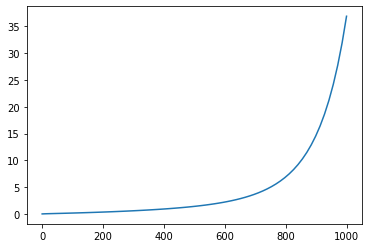

In [29]:
plt.plot(scheduler.timesteps, scheduler.sigmas[:-1]);

Now we go through the (70) timesteps in a for loop 
```for i, t in enumerate(tqdm(scheduler.timesteps)):``` <br>
concatenating our two noise bits together, ```input_ts = torch.cat([latents] * 2)``` <br>
because we've got the classifier free and the prompt versions.<br>
Then do the scaling, ```input = scheduler.scale_model_input(input_ts, t)``` <br>
get predictions from the U-net (passing in the "timestep" `t` and the prompt `text_embeddings`). <br>
```Python
 with torch.no_grad():
        pred = unet(input, t, encoder_hidden_states=text_embeddings).sample
```
The Unet returns the 2 parts of the guidance, for the empty string and for the caption. 
We pull them apart with `.chunk(2)` into 2 separate variables.
```pred_uncond, pred_text = pred.chunk(2)```<br>
Now we can do the guidance scale (7.5) 
```pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)```<br>
and update to get the new latents, i.e., compute the previous noisy sample $x_t \rightarrow x_{t-1}$
```Python
latents = scheduler.step(pred, t, latents).prev_sample
```    

In [30]:
from tqdm.auto import tqdm

for i, ts in enumerate(tqdm(scheduler.timesteps)):
    input_ts = torch.cat([latents] * 2)
    input = scheduler.scale_model_input(input_ts, ts)

    # predict the noise residual
    with torch.no_grad():
        pred = unet(input, ts, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    pred_uncond, pred_text = pred.chunk(2)   #pull them apart
    pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)

    # compute the previous noisy sample x_ts -> x_ts-1
    latents = scheduler.step(pred, ts, latents).prev_sample

  0%|          | 0/70 [00:00<?, ?it/s]

After the loop above completes the `latents` contain a denoised representation of the image. <br>
Per paper, we need to divide it by `0.18215` to scale it correctly.<br>
Then use the *vae* decoder to convert it back to pixel space. 

In [31]:
latents = 1 / 0.18215 * latents

with torch.no_grad():
    image = vae.decode(latents).sample

In [32]:
image.shape

torch.Size([1, 3, 512, 512])

Now we have numbers between -1 and 1, but PIL, the *Python Imaging Library* expects:
numbers between 0 and 1, so we `clamp`,
a different order so we need to permute the image, 
And then convert to between 0 and 255 as `uint8`, which is what PIL really wants.
And there's our picture. 

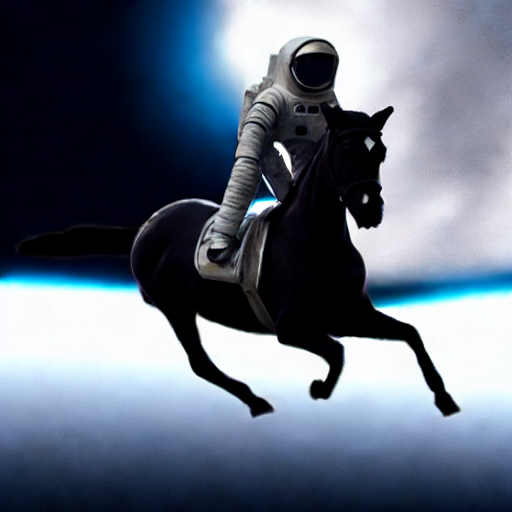

In [33]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image[0].detach().cpu().permute(1,2,0).numpy()
image = (image * 255).round().astype("uint8")
Image.fromarray(image)

## Just the Code
combined in one screen at once.

In [34]:
prompts = [
    'a 4K photograph of an astronaut riding a horse',
    'an oil painting of an astronaut riding a horse in the style of grant wood'
]

In [35]:
text_input = tokenizer(prompts, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_embeddings = text_encoder(text_input.input_ids.to("cuda"))[0].half()

In [36]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * len(prompts), padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to("cuda"))[0].half()
emb = torch.cat([uncond_embeddings, text_embeddings])

Coding best practice: Software Engineers like long words as variable names, mathematicians like short, e.g., letters.
Turning long variable names to single letters makes it easier to experiment, understand how it behaves,
manipulate algebraically and make it look like the paper.<br>
`g` is guidance scale, and `u, t` the unconditional and text embeddings.

In [37]:
torch.manual_seed(100)
g = guidance_scale

In [38]:
latents = torch.randn((len(prompts), unet.in_channels, height//8, width//8))
scheduler.set_timesteps(num_inference_steps)
latents = latents.to("cuda").half() * scheduler.init_noise_sigma

In [39]:
for i,ts in enumerate(tqdm(scheduler.timesteps)):
    inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
    with torch.no_grad(): 
        u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
    pred = u + g*(t-u)
    latents = scheduler.step(pred, ts, latents).prev_sample

  0%|          | 0/70 [00:00<?, ?it/s]

In [40]:
with torch.no_grad(): image = vae.decode(1 / 0.18215 * latents).sample
res = (image / 2 + 0.5).clamp(0, 1)

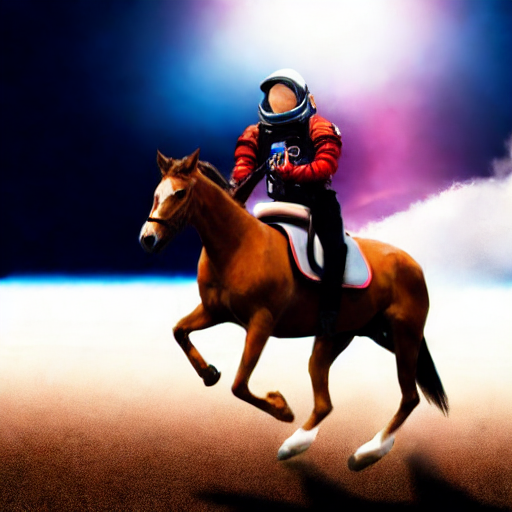

In [41]:
image = res[0].detach().cpu().permute(1, 2, 0).numpy()
image = (image * 255).round().astype("uint8")
Image.fromarray(image)

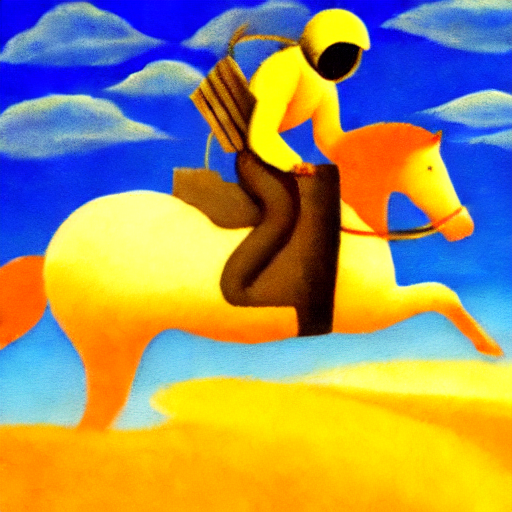

In [42]:
image = res[1].detach().cpu().permute(1, 2, 0).numpy()
image = (image * 255).round().astype("uint8")
Image.fromarray(image)

## Put it in functions
Now everything fits in the 2 cells below

In [43]:
def text_enc(prompts, maxlen=None):
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
    return text_encoder(inp.input_ids.to("cuda"))[0].half()

def mk_img(t):
    image = (t/2+0.5).clamp(0,1).detach().cpu().permute(1, 2, 0).numpy()
    return Image.fromarray((image*255).round().astype("uint8"))

In [44]:
def mk_samples(prompts, g=7.5, seed=100, steps=70):
    bs = len(prompts)
    text = text_enc(prompts)
    uncond = text_enc([""] * bs, text.shape[1])
    emb = torch.cat([uncond, text])
    if seed: torch.manual_seed(seed)

    latents = torch.randn((bs, unet.in_channels, height//8, width//8))
    scheduler.set_timesteps(steps)
    latents = latents.to("cuda").half() * scheduler.init_noise_sigma

    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
        pred = u + g*(t-u)
        latents = scheduler.step(pred, ts, latents).prev_sample

    with torch.no_grad(): return vae.decode(1 / 0.18215 * latents).sample

In [45]:
images = mk_samples(prompts, steps=100, seed=1000)

  0%|          | 0/100 [00:00<?, ?it/s]

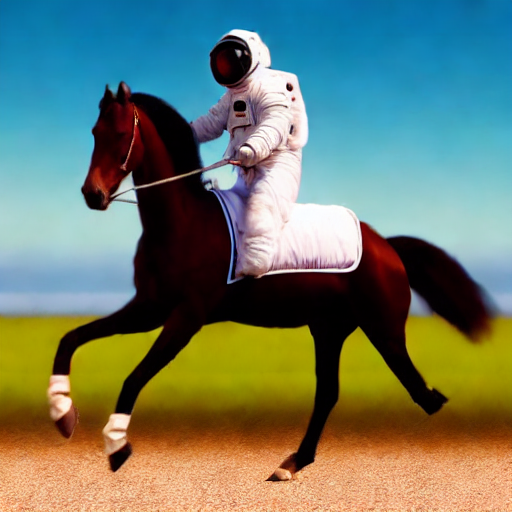

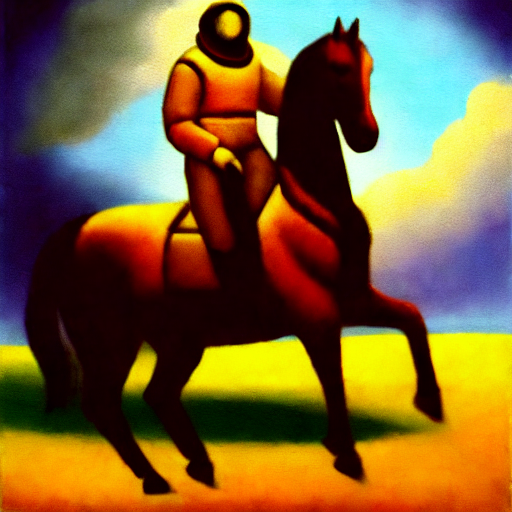

In [46]:
from IPython.display import display

for img in images: display(mk_img(img))

## homework
- Implement one of the extra tricks we learned (image to image or negative prompts),
- adding callbacks  (don't need to wait for the diffusers folks to update the library)

### Implement negative_prompt